# fMRI Data Loading and Normalization in Python 
**V.0.2 - Beta, [Contributions](#contributions)**   

### Goal of this script
 1. load the fMRI data into python
     - 2 localizer runs
 2. create an average brain mask from multiple runs
     - ses00_brain (2 localizer runs)
 3. trim TRs from the beginning AND end of each run (and apply this trimming to the confounds as well). Number of volumes trimmed defined by n_trunc_beginning and n_trunc_end. 
     - save volume as _trimXandXTRs.nii.gz
 4. apply a high-pass filter and z-score the data
     - save volume as _trimXandXTRs_normalized.nii.gz
 5. concatonate runs to make one time series
     - concatenated volumes saved as run-ALL
 6. plot a timeseries for a voxel

## Define subject

In [10]:
sub = 'sub-005'
ses = 'ses-01'
task='imagine'
n_trunc_beginning=5 #Number of volumes to trim from beginning of run
n_trunc_end=10 #Number of volumes to trim from end of run

## Import necessary packages

In [2]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker
from nilearn.masking import intersect_masks
from nilearn import image
from nilearn.plotting import plot_roi
from nilearn.plotting import plot_anat
from nilearn.plotting import plot_epi
from nilearn.image.image import mean_img
from scipy import stats
from sklearn import preprocessing
import matplotlib.pyplot as plt 
#import seaborn as sns 
import scipy.io
import importlib

%matplotlib inline 
%autosave 5
#sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

Autosaving every 5 seconds


## Load settings

In [11]:
# load some helper functions
sys.path.insert(0, '/jukebox/norman/karina/adderzip_fMRI/adderzip/code/analysis/mainanalysis')
import adderzip_utils_imagine
from adderzip_utils_imagine import load_adderzip_epi_data, load_data

# load some constants
from adderzip_utils_imagine import adderzip_dir, adderzip_bids_dir, adderzip_TR, adderzip_hrf_lag, run_names, run_order_start, n_runs, TRs_run

importlib.reload(adderzip_utils_imagine)

print('TASK:', task)
print('LIST OF TASKS:', run_names)
task_index = run_names.index(task)
print('task index:', task_index)
print('')

adderzip_n_runs = n_runs[task_index]
adderzip_TRs_run = TRs_run[0]
adderzip_TRs_run_extra = TRs_run[3]

bold_dir=adderzip_bids_dir + 'derivatives/fmriprep/%s/%s/func/' % (sub, ses)
anat_dir=adderzip_bids_dir + 'derivatives/deface/'
out_dir= adderzip_bids_dir + 'derivatives/firstlevel/%s/%s/' % (sub, ses)
mask_fold = adderzip_bids_dir + 'derivatives/firstlevel/%s/masks/' % sub

print('bids dir = %s' % (adderzip_bids_dir))
print('')
print('subject dir = %s' % (bold_dir))
print('')
print('output dir = %s' % (out_dir))
print('')
print('number of runs = %d' % (adderzip_n_runs))
print('TR = %s seconds' % (adderzip_TR))
print('TRs per run = %s' % (adderzip_TRs_run))
print('TRs per run for 9th run = %s' % (adderzip_TRs_run_extra))
print('trim %d volumes from beginning of each run' % (n_trunc_beginning))
print('trim %d volumes from end of each run' % (n_trunc_end))


TASK: imagine
LIST OF TASKS: ['imagine']
task index: 0

bids dir = /jukebox/norman/karina/adderzip_fMRI/adderzip/data/bids/

subject dir = /jukebox/norman/karina/adderzip_fMRI/adderzip/data/bids/derivatives/fmriprep/sub-005/ses-01/func/

output dir = /jukebox/norman/karina/adderzip_fMRI/adderzip/data/bids/derivatives/firstlevel/sub-005/ses-01/

number of runs = 2
TR = 1.5 seconds
TRs per run = 159
TRs per run for 9th run = 231
trim 5 volumes from beginning of each run
trim 10 volumes from end of each run


## Select confounds and trim volumes from confounds file
Choose the desired confounds from the confounds_regressors.tsv file from fmriprep, trim the columns corresponding to trimmed volumes, and save as a .txt file. 

In [12]:
# Use only the last 6 columns
confounds=[]
mc_all=[]

#adding +1 to trunc because there's an extra TR for 005
for r in range(run_order_start[1],run_order_start[1]+n_runs[0]):
    fname='_ses-01_task-imagine_run-%i_desc-confounds_timeseries.tsv' % (r)
    confounds = pd.read_csv(bold_dir + sub + fname,  sep='\t', header=(0))
    #confounds_selected=confounds[['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']][n_trunc_beginning:] #only trim beginning
    
    print('before trimming')
    print(confounds.shape)
    
    confounds_selected=confounds[['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']][n_trunc_beginning:-(n_trunc_end+1)]
    confounds_selected=pd.DataFrame(confounds_selected)
    confounds_selected.to_csv(out_dir + sub + '_ses-01_task-imagine_run-0%i_confounds_selected_trim%dand%dTRs.txt' % (r, n_trunc_beginning, n_trunc_end), index=False, sep='\t', mode='w')
    
    print('run #%d' % (r))
    print(confounds_selected)

before trimming
(160, 211)
run #8
      trans_x   trans_y   trans_z     rot_x     rot_y     rot_z
5   -0.021515  0.010395 -0.024519 -0.000011 -0.001122 -0.000173
6   -0.012455 -0.057256 -0.055946  0.000526 -0.000950 -0.000055
7   -0.003377 -0.033800 -0.072073  0.000534 -0.000950  0.000188
8   -0.013026  0.019532 -0.042784 -0.000152 -0.001393  0.000058
9   -0.014457 -0.065523 -0.064624  0.000833 -0.001065 -0.000083
..        ...       ...       ...       ...       ...       ...
144  0.057210 -0.027861 -0.095238  0.000440 -0.002724  0.001232
145  0.063350  0.052897 -0.015306 -0.000267 -0.002882  0.001038
146  0.059309 -0.033527 -0.047967  0.000208 -0.003143  0.001232
147  0.063198  0.040055 -0.019292 -0.000214 -0.003277  0.001232
148  0.061325 -0.046263 -0.047953  0.000629 -0.003129  0.001358

[144 rows x 6 columns]
before trimming
(232, 277)
run #9
      trans_x   trans_y   trans_z     rot_x     rot_y         rot_z
5    0.000005 -0.009880  0.002474  0.000035  0.000293 -1.654360e-24
6   

## Create an average mask

Make an average mask by intersecting the mask for each run. Plot average mask overlayed on subject's defaced T1. 

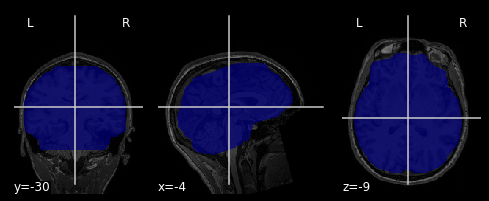

In [13]:
mask_imgs=[]
for run in range(run_order_start[1],run_order_start[1]+n_runs[0]):
    mask_name = bold_dir + sub + '_ses-01_task-imagine_run-%i_space-T1w_desc-brain_mask.nii.gz' % run
    mask_imgs.append(mask_name)
    
avg_mask=intersect_masks(mask_imgs, threshold=0.5, connected=True)

# plot
t1_file = anat_dir + sub + '_ses-01_desc-preproc_T1w_defaced.nii.gz'
t1_img = image.load_img(t1_file)
plot_roi(avg_mask, bg_img=t1_img)

In [14]:
# Save the mask
output_name = mask_fold + '%s_%s_imagine_brain.nii.gz' % (sub, ses)
print('Save average mask:', output_name)
print('')

dimsize=avg_mask.header.get_zooms()
affine_mat = avg_mask.affine
print('Mask dimensions:', dimsize)
print('')
print('Affine:')
print(affine_mat)

hdr = avg_mask.header  # get a handle for the .nii file's header
hdr.set_zooms((dimsize[0], dimsize[1], dimsize[2]))
nib.save(avg_mask, output_name)

Save average mask: /jukebox/norman/karina/adderzip_fMRI/adderzip/data/bids/derivatives/firstlevel/sub-005/masks/sub-005_ses-01_imagine_brain.nii.gz

Mask dimensions: (1.5, 1.5, 1.5)

Affine:
[[   1.5    0.     0.   -77. ]
 [   0.     1.5    0.  -110.5]
 [   0.     0.     1.5  -86.5]
 [   0.     0.     0.     1. ]]


## Drop first few TRs & last few TRs

`n_trunc` sets the number of TRs to drop.

In [20]:
epi_trunc=[]
for run in range(run_order_start[1],run_order_start[1]+n_runs[0]):
    epi_file=bold_dir + sub + '_ses-01_task-imagine_run-%i_space-T1w_desc-preproc_bold.nii.gz' % run
    epi_data=nib.load(epi_file)
    epi=epi_data.get_fdata()
    #hdr=epi_data.get_data.hdr()
    
    # TRIM BEGINNING AND END
    epi_trunc =np.zeros((epi_data.shape[0], epi_data.shape[1], epi_data.shape[2], epi_data.shape[3]-n_trunc_beginning-(n_trunc_end+1)))
    epi_trunc[:, :, :, :] = epi[:,:,:,n_trunc_beginning:-(n_trunc_end+1)]
    
    #epi_truncated
    print('run #%d' % (run))
    print('Original:', epi_data.shape, '  ', 'Truncated:', epi_trunc.shape)
    dimsize=epi_data.header.get_zooms()
    print('Dimensions:', dimsize)
    orig_dimsize=dimsize
    
    affine_mat = epi_data.affine  # What is the orientation of the data
    print('Affine:')
    print(affine_mat)
    print('')
    
    # Save the volume
    output_name = (out_dir + '%s_ses-01_task-imagine_run-0%i_space-T1w_desc-preproc_bold_trim%dand%dTRs.nii.gz' % (sub, run, n_trunc_beginning, n_trunc_end))
    bold_nii = nib.Nifti1Image(epi_trunc, affine_mat)
    hdr = bold_nii.header  # get a handle for the .nii file's header
    hdr.set_zooms((dimsize[0], dimsize[1], dimsize[2], dimsize[3]))
    nib.save(bold_nii, output_name)
    
    print('bold shape:', bold_nii.shape)

run #8
Original: (98, 112, 92, 160)    Truncated: (98, 112, 92, 144)
Dimensions: (1.5, 1.5, 1.5, 1.5)
Affine:
[[   1.5    0.     0.   -77. ]
 [   0.     1.5    0.  -110.5]
 [   0.     0.     1.5  -86.5]
 [   0.     0.     0.     1. ]]

bold shape: (98, 112, 92, 144)
run #9
Original: (98, 112, 92, 232)    Truncated: (98, 112, 92, 216)
Dimensions: (1.5, 1.5, 1.5, 1.5)
Affine:
[[   1.5    0.     0.   -77. ]
 [   0.     1.5    0.  -110.5]
 [   0.     0.     1.5  -86.5]
 [   0.     0.     0.     1. ]]

bold shape: (98, 112, 92, 216)


## Load fMRI data <a id="load_fmri"></a>

#### Get voxels from an ROI

We will extract BOLD data, only for voxels in a mask, by executing the following sequence of steps: 
1. load whole brain fMRI data (for a given subject and a given run)
2. load the desired mask
3. use `NiftiMasker` to sub-select mask voxels from the whole brain data
    - `NiftiMasker` is a function from nilearn. Here's <a href="https://nilearn.github.io/auto_examples/04_manipulating_images/plot_mask_computation.html">an example</a> about how to use it, and here's the official <a href="https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMasker.html">documentation</a>. 

## Apply mask to truncated dataset

In [21]:
epi_mask_data_all=[]

# 1. Load the fMRI data 
for run in range(run_order_start[1],run_order_start[1]+n_runs[0]):

    epi_masker= NiftiMasker(
        mask_img=avg_mask,  
        high_pass=1/128,
        standardize=True,  # Are you going to zscore the data across time?
        t_r=adderzip_TR, 
        #memory='nilearn_cache',  # Caches the mask in the directory given as a string here so that it is easier to load and retrieve
        #memory_level=1,  # How much memory will you cache?
        verbose=0
    )

    epi_file=out_dir + '%s_ses-01_task-imagine_run-0%i_space-T1w_desc-preproc_bold_trim%dand%dTRs.nii.gz' % (sub, run, n_trunc_beginning, n_trunc_end)
    # confound_file= bold_dir + '%s_confounds_selected_r0%i.txt' % (sub, run)
    
    # epi_mask_data = epi_masker.fit_transform(epi_file, confounds=confound_file)
    epi_mask_data = epi_masker.fit_transform(epi_file)

    if run==run_order_start[1]:
        epi_mask_data_all=epi_mask_data
    else:
        epi_mask_data_all=np.vstack([epi_mask_data_all,epi_mask_data])
        
    # Save the volume
    print('Saving trimmed and normalized volume for run', run)
    
    affine_mat = avg_mask.affine #should be the same as the epi data
    avg_mask.shape
    coords = np.where(avg_mask.get_fdata())
    bold_vol=[]
    bold_vol =np.zeros((avg_mask.shape[0], avg_mask.shape[1], avg_mask.shape[2], epi_mask_data.shape[0]))
    bold_vol[coords[0], coords[1], coords[2], :] = epi_mask_data.T
    print('epi_mask_data shape:', bold_vol.shape)
    print('')
    
    output_name = (out_dir + '%s_ses-01_task-imagine_run-0%i_space-T1w_desc-preproc_bold_trim%dand%dTRs_normalized.nii.gz' % (sub, run, n_trunc_beginning, n_trunc_end))
    bold_nii = nib.Nifti1Image(bold_vol, affine_mat)
    hdr = bold_nii.header  # get a handle for the .nii file's header
    hdr.set_zooms((orig_dimsize[0], orig_dimsize[1], orig_dimsize[2], orig_dimsize[3]))
    nib.save(bold_nii, output_name)

print('Volumes saved')
print(epi_mask_data_all.shape)

Saving trimmed and normalized volume for run 8
epi_mask_data shape: (98, 112, 92, 144)

Saving trimmed and normalized volume for run 9
epi_mask_data shape: (98, 112, 92, 216)

Volumes saved
(360, 411384)


In [22]:
avg_mask.shape
coords = np.where(avg_mask.get_fdata())
#print(avg_mask)

dimsize=avg_mask.header.get_zooms()
print('Voxel dimensions:', dimsize)

affine_mat = avg_mask.affine  # What is the orientation of the data

bold_vol=[]
bold_vol =np.zeros((avg_mask.shape[0], avg_mask.shape[1], avg_mask.shape[2], epi_mask_data_all.shape[0]))
bold_vol[coords[0], coords[1], coords[2], :] = epi_mask_data_all.T

print('avg_mask shape:', avg_mask.shape)
print('epi_mask_data shape:', bold_vol.shape)
print('epi_mask_data_all shape(timepoints, voxels):', epi_mask_data_all.shape)

Voxel dimensions: (1.5, 1.5, 1.5)
avg_mask shape: (98, 112, 92)
epi_mask_data shape: (98, 112, 92, 360)
epi_mask_data_all shape(timepoints, voxels): (360, 411384)


In [ ]:
# Save the concatenated volume
output_name = out_dir + '%s_ses-01_task-imagine_run-ALL_space-T1w_desc-preproc_bold_trim%dand%dTRs_normalized.nii.gz' % (sub, n_trunc_beginning, n_trunc_end)
print('Save concatenated data:', output_name)
print('')
bold_nii = nib.Nifti1Image(bold_vol, affine_mat)
hdr = bold_nii.header  # get a handle for the .nii file's header
print('Dimensions:', orig_dimsize) #4th dimension is TR
print('')
hdr.set_zooms((orig_dimsize[0], orig_dimsize[1], orig_dimsize[2], orig_dimsize[3]))
nib.save(bold_nii, output_name)
print('Volume saved')

Save concatenated data: /jukebox/norman/karina/adderzip_fMRI/adderzip/data/bids/derivatives/firstlevel/sub-005/ses-01/sub-005_ses-01_task-imagine_run-ALL_space-T1w_desc-preproc_bold_trim5and10TRs_normalized.nii.gz

Dimensions: (1.5, 1.5, 1.5, 1.5)

Volume saved


## Plot a volume from each run to check normalization step

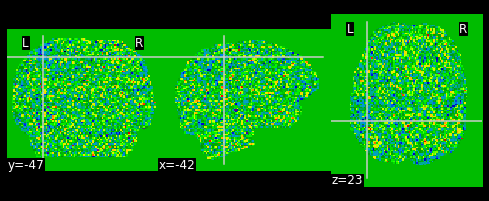

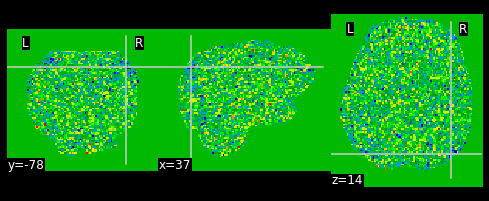

In [28]:
vol_num=0
for run in range(run_order_start[1],run_order_start[1]+n_runs[0]):
     func_name = (out_dir + '%s_ses-01_task-imagine_run-0%i_space-T1w_desc-preproc_bold_trim%dand%dTRs_normalized.nii.gz' % (sub, run, n_trunc_beginning, n_trunc_end))
     image.load_img(func_name)
     first_vol = image.index_img(func_name,vol_num)
     #mean_func = mean_img(func_name)
     plot_epi(first_vol)

### 3.1. Plot a voxel time-series <a id="plot_voxel"></a>

After masking, the fMRI dataset at this stage (found in the variable epi_mask_data that was created in the cell above) is in the format rows=time (i.e. 310 rows referring to 310 TRs) and columns=voxels (i.e. the number of voxels in the mask).

Text(0, 0.5, 'Voxel Intensity')

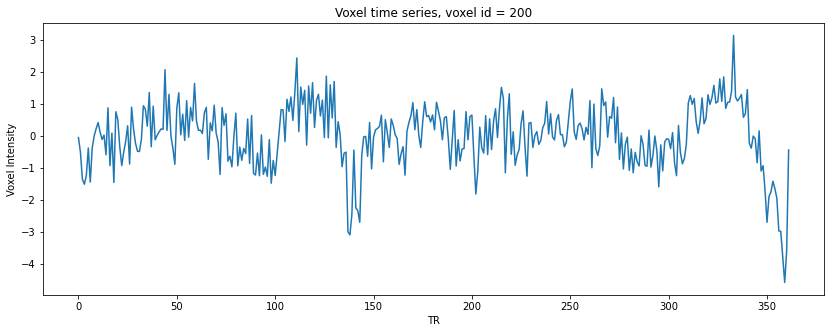

In [29]:
# Plot value of voxel_id through time point 550 (there are only 538 time points)
voxel_id = 200

f, ax = plt.subplots(1,1, figsize=(14,5))
ax.plot(epi_mask_data_all[:, voxel_id])

ax.set_title('Voxel time series, voxel id = %d' % voxel_id)
ax.set_xlabel('TR')
ax.set_ylabel('Voxel Intensity')

# plt.figure(figsize=(10,10))
# plt.imshow(epi_mask_data_all[200:300,voxel_id-100:voxel_id+100])
# plt.colorbar()
# plt.show()

## Check mean and standard deviation of normalized data 

In [30]:
x_mean = np.mean(epi_mask_data_all, axis=0)
x_std = np.std(epi_mask_data_all, axis=0, dtype=np.float64)

print('the mean of 1st few time points:\n', x_mean[0:10])
print('')
print('the std of 1st few time points:\n', x_std[0:10])
print('')
print(np.shape(x_mean))
print(np.shape(x_std))
print('')
print(np.amin(x_mean), np.amax(x_mean))
print(np.amin(x_std), np.amax(x_std))

# print(x_std)

the mean of 1st few time points:
 [ 2.69888470e-17 -2.26951668e-17 -1.36477692e-17  1.66380108e-17
 -3.09758358e-17 -4.14033448e-18  5.52044598e-18 -2.39602690e-17
  1.80181223e-17 -3.11291815e-17]

the std of 1st few time points:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

(411384,)
(411384,)

-1.9777764447656018e-16 2.3845259713979535e-16
0.9999999999999986 1.0000000000000013


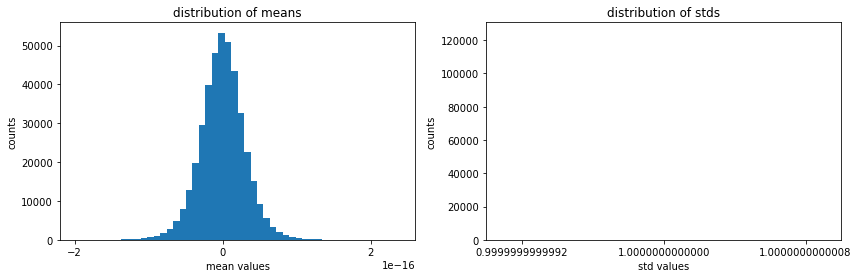

In [31]:
f, axes = plt.subplots(1, 2, figsize = (14,4))

n_bins = 50

axes[0].hist(x_mean, bins = n_bins)
axes[0].set_title('distribution of means')
axes[0].set_xlabel('mean values')
axes[0].set_ylabel('counts')
axes[0].xaxis.set_major_locator(plt.MaxNLocator(3))

axes[1].hist(x_std, bins = n_bins)
axes[1].set_title('distribution of stds')
axes[1].set_xlabel('std values')
axes[1].set_ylabel('counts')
axes[1].xaxis.set_major_locator(plt.MaxNLocator(3))
axes[1].get_xaxis().get_major_formatter().set_useOffset(False)

plt.show()